In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from lightgbm import LGBMClassifier
from category_encoders import CatBoostEncoder

In [2]:
X, y = make_classification(
    n_samples=200_000,
    n_features=500,
    n_clusters_per_class=1,
    n_informative=150,
    random_state=42,
)

df = pd.DataFrame(X, columns=[f"var_{x}" for x in range(0, len(X[0]))])
df['target'] = y



In [3]:
from galileo.telescope import IterativeFeatureSelection

In [4]:
ifs = IterativeFeatureSelection(dataframe=df, test_size=0.33, target_name='target', sample_size=30_000, threshold=0.02, metric='roc_auc')

Sampling data with a sample size of 30000 observations
Splitting data into training and testing sets...
Building score-feature tradeoff curve
Fitting model...


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]

Done!
Optimal % of features is: 57.99999999999999
Score for metric roc_auc: 0.987
0.48846253490877395
0.9926948079774599


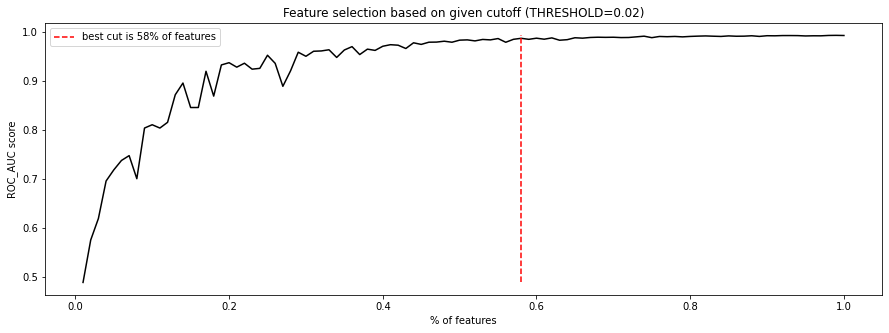

In [5]:
ifs.build_selection_curve()

In [8]:
test = df[df.duplicated(['var_0', 'var_1'])] if True else False

In [99]:
sample = df.sample(n=30_000, random_state=42)
features = list(filter(lambda x: x != "target", df.columns.values))

X_train, X_test, y_train, y_test = train_test_split(sample[features], sample['target'], test_size=0.33, stratify=sample['target'])
scores = list()
fraction_score_pair = list()

fractions = list(range(1, 101))
fractions = list(map(lambda x: x/100, fractions))

for fraction in tqdm(fractions):
    pipe = Pipeline([('encoder', CatBoostEncoder(verbose=-1)), ('estimator', LGBMClassifier(random_state=42, verbosity=-1))])
    size = round(len(features) * fraction)
    sample_features = np.random.choice(features, size=size, replace=False)

    pipe.fit(X_train[sample_features], y_train)
    y_scores = pipe.predict_proba(X_test[sample_features])[:, 1]

    score = roc_auc_score(y_test, y_scores)
    scores.append(score)
    fraction_score_pair.append((fraction, score))


reverse_scores = scores[::-1]
deltas = [round((reverse_scores[0] - score) / reverse_scores[0], 4) for score in reverse_scores[1:]]

least_than_threshold = list(filter(lambda x: x <= 0.02, deltas))
best_value = max(least_than_threshold)
idx = deltas.index(best_value)
best_fraction = fractions[:-1][idx]


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.59it/s]

  3%|▎         | 3/100 [00:00<00:19,  5.04it/s]

  4%|▍         | 4/100 [00:00<00:21,  4.54it/s]

  5%|▌         | 5/100 [00:01<00:22,  4.19it/s]

  6%|▌         | 6/100 [00:01<00:24,  3.78it/s]

  7%|▋         | 7/100 [00:01<00:26,  3.45it/s]

  8%|▊         | 8/100 [00:02<00:29,  3.13it/s]

  9%|▉         | 9/100 [00:02<00:31,  2.88it/s]

 10%|█         | 10/100 [00:03<00:35,  2.55it/s]

 11%|█         | 11/100 [00:03<00:37,  2.36it/s]

 12%|█▏        | 12/100 [00:04<00:40,  2.15it/s]

 13%|█▎        | 13/100 [00:04<00:43,  1.99it/s]

 14%|█▍        | 14/100 [00:05<00:46,  1.86it/s]

 15%|█▌        | 15/100 [00:05<00:48,  1.74it/s]

 16%|█▌        | 16/100 [00:06<00:49,  1.68it/s]

 17%|█▋        | 17/100 [00:07<00:51,  1.60it/s]

 18%|█▊        | 18/100 [00:08<00:54,  1.50it/s]

 19%|█▉        | 19/100 [00:08<00:56,  1.44it/s]

 20%|██        | 20/100 [00:09<00:59,  1.34it/s]

 21%|██        | 21/100 [00:10<01:01,  1.28it/s]

 22%|██▏       | 22/100 [00:11<01:07,  1.16it/s]

 23%|██▎       | 23/100 [00:12<01:11,  1.08it/s]

 24%|██▍       | 24/100 [00:13<01:13,  1.03it/s]

 25%|██▌       | 25/100 [00:14<01:16,  1.02s/it]

 26%|██▌       | 26/100 [00:16<01:17,  1.05s/it]

 27%|██▋       | 27/100 [00:17<01:19,  1.09s/it]

 28%|██▊       | 28/100 [00:18<01:20,  1.11s/it]

 29%|██▉       | 29/100 [00:19<01:19,  1.12s/it]

 30%|███       | 30/100 [00:20<01:21,  1.16s/it]

 31%|███       | 31/100 [00:22<01:25,  1.24s/it]

 32%|███▏      | 32/100 [00:23<01:27,  1.29s/it]

 33%|███▎      | 33/100 [00:24<01:26,  1.30s/it]

 34%|███▍      | 34/100 [00:26<01:27,  1.32s/it]

 35%|███▌      | 35/100 [00:27<01:27,  1.34s/it]

 36%|███▌      | 36/100 [00:29<01:28,  1.38s/it]

 37%|███▋      | 37/100 [00:30<01:32,  1.46s/it]

 38%|███▊      | 38/100 [00:32<01:31,  1.47s/it]

 39%|███▉      | 39/100 [00:33<01:30,  1.48s/it]

 40%|████      | 40/100 [00:35<01:31,  1.52s/it]

 41%|████      | 41/100 [00:37<01:32,  1.57s/it]

 42%|████▏     | 42/100 [00:38<01:33,  1.61s/it]

 43%|████▎     | 43/100 [00:40<01:32,  1.63s/it]

 44%|████▍     | 44/100 [00:42<01:34,  1.68s/it]

 45%|████▌     | 45/100 [00:44<01:33,  1.71s/it]

 46%|████▌     | 46/100 [00:46<01:37,  1.80s/it]

 47%|████▋     | 47/100 [00:48<01:39,  1.87s/it]

 48%|████▊     | 48/100 [00:49<01:38,  1.89s/it]

 49%|████▉     | 49/100 [00:51<01:36,  1.90s/it]

 50%|█████     | 50/100 [00:53<01:35,  1.92s/it]

 51%|█████     | 51/100 [00:55<01:35,  1.94s/it]

 52%|█████▏    | 52/100 [00:57<01:35,  1.99s/it]

 53%|█████▎    | 53/100 [01:00<01:35,  2.02s/it]

 54%|█████▍    | 54/100 [01:02<01:38,  2.14s/it]

 55%|█████▌    | 55/100 [01:04<01:37,  2.16s/it]

 56%|█████▌    | 56/100 [01:06<01:35,  2.18s/it]

 57%|█████▋    | 57/100 [01:09<01:35,  2.22s/it]

 58%|█████▊    | 58/100 [01:11<01:37,  2.31s/it]

 59%|█████▉    | 59/100 [01:14<01:35,  2.32s/it]

 60%|██████    | 60/100 [01:16<01:34,  2.36s/it]

 61%|██████    | 61/100 [01:19<01:34,  2.42s/it]

 62%|██████▏   | 62/100 [01:21<01:32,  2.44s/it]

 63%|██████▎   | 63/100 [01:24<01:31,  2.48s/it]

 64%|██████▍   | 64/100 [01:26<01:31,  2.54s/it]

 65%|██████▌   | 65/100 [01:29<01:30,  2.58s/it]

 66%|██████▌   | 66/100 [01:32<01:29,  2.63s/it]

 67%|██████▋   | 67/100 [01:35<01:29,  2.70s/it]

 68%|██████▊   | 68/100 [01:38<01:27,  2.74s/it]

 69%|██████▉   | 69/100 [01:40<01:26,  2.79s/it]

 70%|███████   | 70/100 [01:43<01:25,  2.84s/it]

 71%|███████   | 71/100 [01:46<01:23,  2.87s/it]

 72%|███████▏  | 72/100 [01:49<01:22,  2.93s/it]

 73%|███████▎  | 73/100 [01:52<01:20,  2.97s/it]

 74%|███████▍  | 74/100 [01:56<01:18,  3.01s/it]

 75%|███████▌  | 75/100 [01:59<01:16,  3.06s/it]

 76%|███████▌  | 76/100 [02:02<01:15,  3.15s/it]

 77%|███████▋  | 77/100 [02:05<01:13,  3.18s/it]

 78%|███████▊  | 78/100 [02:09<01:15,  3.45s/it]

 79%|███████▉  | 79/100 [02:13<01:14,  3.53s/it]

 80%|████████  | 80/100 [02:17<01:13,  3.68s/it]

 81%|████████  | 81/100 [02:23<01:20,  4.26s/it]

 82%|████████▏ | 82/100 [02:27<01:18,  4.35s/it]

 83%|████████▎ | 83/100 [02:31<01:11,  4.23s/it]

 84%|████████▍ | 84/100 [02:35<01:05,  4.07s/it]

 85%|████████▌ | 85/100 [02:39<00:59,  3.98s/it]

 86%|████████▌ | 86/100 [02:42<00:54,  3.90s/it]

 87%|████████▋ | 87/100 [02:47<00:52,  4.02s/it]

 88%|████████▊ | 88/100 [02:51<00:50,  4.17s/it]

 89%|████████▉ | 89/100 [02:55<00:45,  4.13s/it]

 90%|█████████ | 90/100 [02:59<00:40,  4.06s/it]

 91%|█████████ | 91/100 [03:03<00:36,  4.03s/it]

 92%|█████████▏| 92/100 [03:07<00:32,  4.02s/it]

 93%|█████████▎| 93/100 [03:11<00:28,  4.05s/it]

 94%|█████████▍| 94/100 [03:15<00:24,  4.06s/it]

 95%|█████████▌| 95/100 [03:20<00:20,  4.08s/it]

 96%|█████████▌| 96/100 [03:24<00:16,  4.13s/it]

 97%|█████████▋| 97/100 [03:28<00:12,  4.21s/it]

 98%|█████████▊| 98/100 [03:33<00:08,  4.28s/it]

 99%|█████████▉| 99/100 [03:37<00:04,  4.32s/it]

100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


In [171]:
sample = df.sample(n=30_000, random_state=42)
features = list(filter(lambda x: x != "target", df.columns.values))

X_train, X_test, y_train, y_test = train_test_split(sample[features], sample['target'], test_size=0.33, stratify=sample['target'])
# scores = list()
fraction_score_pair = list()

fractions = list(range(1, 101))
fractions = list(map(lambda x: x/100, fractions))

for fraction in tqdm(fractions):
    pipe = Pipeline([('encoder', CatBoostEncoder(verbose=-1)), ('estimator', LGBMClassifier(random_state=42, verbosity=-1))])
    size = round(len(features) * fraction)
    sample_features = np.random.choice(features, size=size, replace=False)

    pipe.fit(X_train[sample_features], y_train)
    y_scores = pipe.predict_proba(X_test[sample_features])[:, 1]

    score = roc_auc_score(y_test, y_scores)
    # scores.append(score)
    fraction_score_pair.append((fraction, score))


reverse_scores = fraction_score_pair[::-1]
deltas = [round((reverse_scores[0][1] - score[1]) / reverse_scores[0][1], 4) for score in reverse_scores[1:]]

least_than_threshold = list(filter(lambda x: x <= 0.02, deltas))
best_value = max(least_than_threshold)
idx = deltas.index(best_value)
best_fraction = fractions[:-1][idx]


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:20,  4.93it/s]

  2%|▏         | 2/100 [00:00<00:20,  4.72it/s]

  3%|▎         | 3/100 [00:00<00:22,  4.30it/s]

  4%|▍         | 4/100 [00:00<00:23,  4.05it/s]

  5%|▌         | 5/100 [00:01<00:24,  3.92it/s]

  6%|▌         | 6/100 [00:01<00:26,  3.53it/s]

  7%|▋         | 7/100 [00:01<00:28,  3.23it/s]

  8%|▊         | 8/100 [00:02<00:30,  3.00it/s]

  9%|▉         | 9/100 [00:02<00:33,  2.74it/s]

 10%|█         | 10/100 [00:03<00:35,  2.53it/s]

 11%|█         | 11/100 [00:03<00:37,  2.34it/s]

 12%|█▏        | 12/100 [00:04<00:40,  2.19it/s]

 13%|█▎        | 13/100 [00:04<00:44,  1.98it/s]

 14%|█▍        | 14/100 [00:05<00:47,  1.83it/s]

 15%|█▌        | 15/100 [00:06<00:49,  1.73it/s]

 16%|█▌        | 16/100 [00:06<00:51,  1.64it/s]

 17%|█▋        | 17/100 [00:07<00:52,  1.57it/s]

 18%|█▊        | 18/100 [00:08<00:54,  1.51it/s]

 19%|█▉        | 19/100 [00:09<00:57,  1.40it/s]

 20%|██        | 20/100 [00:09<00:59,  1.34it/s]

 21%|██        | 21/100 [00:10<01:01,  1.29it/s]

 22%|██▏       | 22/100 [00:11<01:02,  1.24it/s]

 23%|██▎       | 23/100 [00:12<01:05,  1.18it/s]

 24%|██▍       | 24/100 [00:13<01:07,  1.13it/s]

 25%|██▌       | 25/100 [00:14<01:09,  1.07it/s]

 26%|██▌       | 26/100 [00:15<01:10,  1.05it/s]

 27%|██▋       | 27/100 [00:16<01:12,  1.01it/s]

 28%|██▊       | 28/100 [00:17<01:14,  1.04s/it]

 29%|██▉       | 29/100 [00:19<01:18,  1.10s/it]

 30%|███       | 30/100 [00:20<01:20,  1.15s/it]

 31%|███       | 31/100 [00:21<01:21,  1.18s/it]

 32%|███▏      | 32/100 [00:22<01:21,  1.20s/it]

 33%|███▎      | 33/100 [00:24<01:22,  1.23s/it]

 34%|███▍      | 34/100 [00:25<01:23,  1.27s/it]

 35%|███▌      | 35/100 [00:26<01:25,  1.32s/it]

 36%|███▌      | 36/100 [00:28<01:26,  1.35s/it]

 37%|███▋      | 37/100 [00:29<01:27,  1.38s/it]

 38%|███▊      | 38/100 [00:31<01:28,  1.43s/it]

 39%|███▉      | 39/100 [00:32<01:29,  1.46s/it]

 40%|████      | 40/100 [00:34<01:30,  1.51s/it]

 41%|████      | 41/100 [00:36<01:36,  1.64s/it]

 42%|████▏     | 42/100 [00:38<01:36,  1.67s/it]

 43%|████▎     | 43/100 [00:40<01:37,  1.72s/it]

 44%|████▍     | 44/100 [00:41<01:37,  1.74s/it]

 45%|████▌     | 45/100 [00:43<01:36,  1.76s/it]

 46%|████▌     | 46/100 [00:45<01:36,  1.79s/it]

 47%|████▋     | 47/100 [00:47<01:37,  1.85s/it]

 48%|████▊     | 48/100 [00:49<01:39,  1.91s/it]

 49%|████▉     | 49/100 [00:51<01:38,  1.94s/it]

 50%|█████     | 50/100 [00:53<01:37,  1.96s/it]

 51%|█████     | 51/100 [00:55<01:37,  1.99s/it]

 52%|█████▏    | 52/100 [00:57<01:37,  2.04s/it]

 53%|█████▎    | 53/100 [00:59<01:37,  2.08s/it]

 54%|█████▍    | 54/100 [01:02<01:37,  2.12s/it]

 55%|█████▌    | 55/100 [01:04<01:36,  2.14s/it]

 56%|█████▌    | 56/100 [01:06<01:36,  2.18s/it]

 57%|█████▋    | 57/100 [01:08<01:35,  2.22s/it]

 58%|█████▊    | 58/100 [01:11<01:34,  2.26s/it]

 59%|█████▉    | 59/100 [01:13<01:35,  2.34s/it]

 60%|██████    | 60/100 [01:16<01:35,  2.39s/it]

 61%|██████    | 61/100 [01:18<01:34,  2.42s/it]

 62%|██████▏   | 62/100 [01:21<01:33,  2.45s/it]

 63%|██████▎   | 63/100 [01:23<01:32,  2.51s/it]

 64%|██████▍   | 64/100 [01:26<01:32,  2.56s/it]

 65%|██████▌   | 65/100 [01:29<01:32,  2.63s/it]

 66%|██████▌   | 66/100 [01:32<01:35,  2.81s/it]

 67%|██████▋   | 67/100 [01:35<01:35,  2.90s/it]

 68%|██████▊   | 68/100 [01:38<01:33,  2.91s/it]

 69%|██████▉   | 69/100 [01:41<01:30,  2.93s/it]

 70%|███████   | 70/100 [01:44<01:29,  2.99s/it]

 71%|███████   | 71/100 [01:47<01:27,  3.00s/it]

 72%|███████▏  | 72/100 [01:50<01:24,  3.03s/it]

 73%|███████▎  | 73/100 [01:54<01:27,  3.24s/it]

 74%|███████▍  | 74/100 [01:58<01:26,  3.34s/it]

 75%|███████▌  | 75/100 [02:01<01:22,  3.31s/it]

 76%|███████▌  | 76/100 [02:04<01:19,  3.30s/it]

 77%|███████▋  | 77/100 [02:08<01:20,  3.51s/it]

 78%|███████▊  | 78/100 [02:12<01:17,  3.54s/it]

 79%|███████▉  | 79/100 [02:15<01:14,  3.56s/it]

 80%|████████  | 80/100 [02:19<01:12,  3.63s/it]

 81%|████████  | 81/100 [02:23<01:09,  3.66s/it]

 82%|████████▏ | 82/100 [02:27<01:06,  3.70s/it]

 83%|████████▎ | 83/100 [02:31<01:03,  3.75s/it]

 84%|████████▍ | 84/100 [02:34<01:00,  3.78s/it]

 85%|████████▌ | 85/100 [02:38<00:57,  3.81s/it]

 86%|████████▌ | 86/100 [02:42<00:53,  3.85s/it]

 87%|████████▋ | 87/100 [02:46<00:50,  3.88s/it]

 88%|████████▊ | 88/100 [02:50<00:46,  3.88s/it]

 89%|████████▉ | 89/100 [02:55<00:44,  4.03s/it]

 90%|█████████ | 90/100 [02:59<00:40,  4.10s/it]

 91%|█████████ | 91/100 [03:03<00:36,  4.10s/it]

 92%|█████████▏| 92/100 [03:08<00:34,  4.27s/it]

 93%|█████████▎| 93/100 [03:12<00:29,  4.27s/it]

 94%|█████████▍| 94/100 [03:16<00:26,  4.37s/it]

 95%|█████████▌| 95/100 [03:21<00:22,  4.48s/it]

 96%|█████████▌| 96/100 [03:27<00:19,  4.79s/it]

 97%|█████████▋| 97/100 [03:32<00:14,  4.89s/it]

 98%|█████████▊| 98/100 [03:36<00:09,  4.76s/it]

 99%|█████████▉| 99/100 [03:41<00:04,  4.69s/it]

100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


In [197]:
fraction_score_pair[:-1][idx]

(0.5, 0.9739270821888892)

In [190]:
idx

49

In [185]:
fraction_score_pair[0][1]

0.5094643855002825

In [6]:
fraction_score_pair

NameError: name 'fraction_score_pair' is not defined

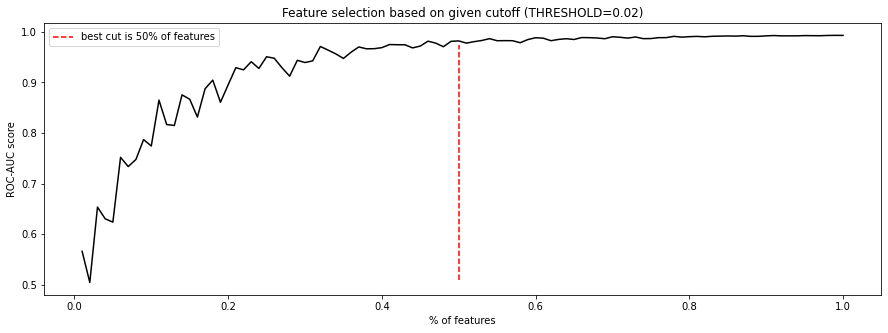

In [186]:
plt.figure(figsize=(15,5))
sns.lineplot(x=fractions, y=scores, color='black')
plt.vlines(x = fraction_score_pair[idx][0], ymin = fraction_score_pair[0][1], ymax = fraction_score_pair[idx][1], color = 'red', label = f'best cut is {round(best_fraction*100)}% of features', linestyles='dashed')
# plt.ylim(0.97, 0.99)
plt.legend()
plt.title(f"Feature selection based on given cutoff (THRESHOLD={0.02})")
plt.ylabel("ROC-AUC score")
plt.xlabel(f"% of features")
plt.show()